# Introduction

This notebook is to train a baseline Logistic Regression Model and to evaluate the results of this model.

## Concepts used

### 1. Sigmoid Activation function
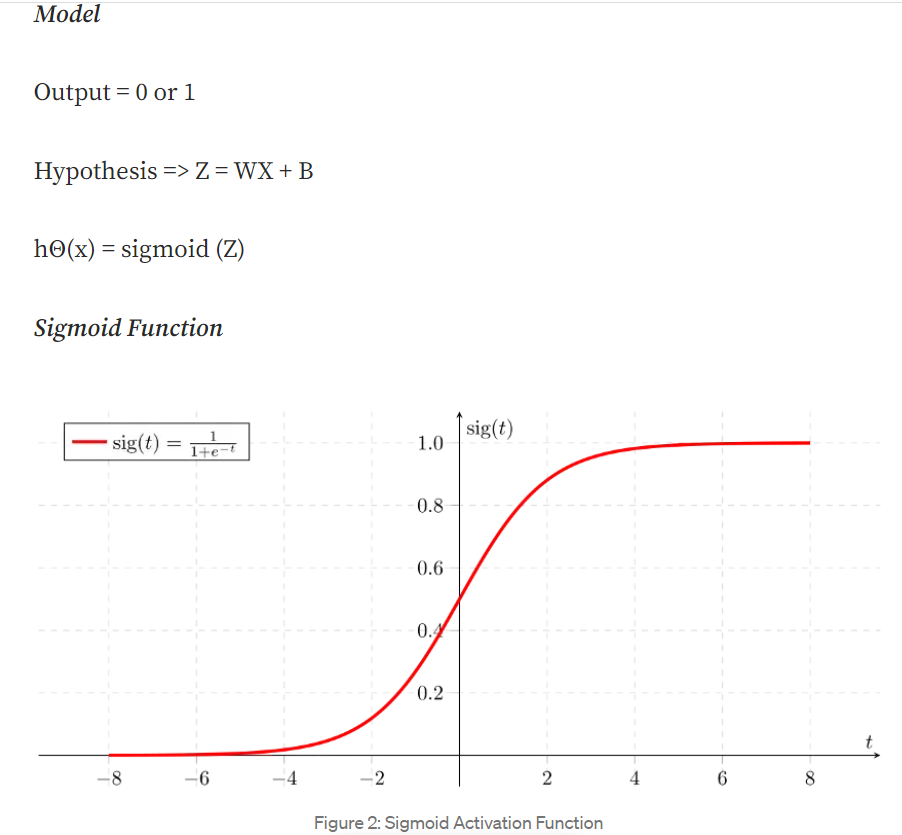

### 2. Log Loss Function
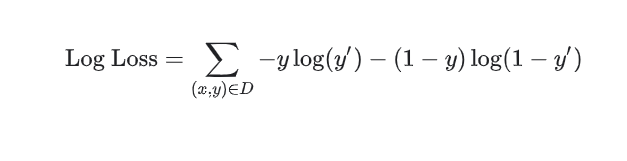

## Import Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2 
import os 
from os.path import join
from random import shuffle 
from tqdm import tqdm 
from PIL import Image

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score



import warnings
import random
warnings.filterwarnings('ignore')


/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
! ls ../data/raw/real_vs_fake/real-vs-fake/

test  train  valid


In [4]:
train_real = r'../data/raw/real_vs_fake/real-vs-fake/train/real/'
train_fake = r'../data/raw/real_vs_fake/real-vs-fake/train/fake/'

val_real = r'../data/raw/real_vs_fake/real-vs-fake/valid/real/'
val_fake = r'../data/raw/real_vs_fake/real-vs-fake/valid/fake/'

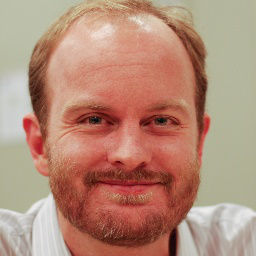

In [5]:
Image.open(join(train_real,random.choice(os.listdir(train_real))))

## Read train images

In [6]:
def get_data(real_data_path, fake_data_path, samp_size = 10, flatten = True, normalize = True,  image_size = 256):
    '''
    Method to collect the data from real and fake folders an join to get train data
    '''
    data_real, real_labels = [], []
    data_fake, fake_labels = [], []
    
    if samp_size == -1:
        real_files = os.listdir(real_data_path)
        fake_files = os.listdir(fake_data_path)
    else:
        real_files = os.listdir(real_data_path)[:samp_size]
        fake_files = os.listdir(fake_data_path)[:samp_size]
        
    for image in tqdm(real_files): 
        path = os.path.join(real_data_path, image)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        data_real.append(img1)
        real_labels.append(1)
        
    for image in tqdm(fake_files): 
        path = os.path.join(fake_data_path, image)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        data_fake.append(img2)
        fake_labels.append(0)
        
    data= np.concatenate((np.asarray(data_real),np.asarray(data_fake)),axis=0)
    if flatten:
        data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
        if normalize:
            data = (data-np.min(data))/(np.max(data)-np.min(data))
            
    label_data = np.concatenate((np.asarray(real_labels),np.asarray(fake_labels)),axis=0)
    
    data, label_data = shuffle(data, label_data, random_state=0)
    return data, label_data

In [7]:
X_train, y_train = get_data(train_real, train_fake, -1, True, True, 128)
X_val, y_val = get_data(val_real, val_fake, -1, True, True, 128)

print(f'Shape of train data {X_train.shape}, shape of train labels {y_train.shape}')
print(f'Shape of train data {X_val.shape}, shape of train labels {y_val.shape}')

100%|██████████| 10000/10000 [00:35<00:00, 284.30it/s]


Shape of train data (100000, 16384), shape of train labels (100000,)
Shape of train data (20000, 16384), shape of train labels (20000,)


## Logistic Regression baseline

In [8]:
log_reg= LogisticRegression(fit_intercept=True,
                        max_iter=100,
                        verbose = True,
                        n_jobs = -1,
                        C = 100)
log_reg.fit(X_train,y_train)

print("Validation accuracy: {} ".format(log_reg.score(X_val, y_val)))
print("Train accuracy: {} ".format(log_reg.score(X_train, y_train)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 215.1min finished


Validation accuracy: 0.76615 
Train accuracy: 0.7766 


### Evaluation on Validation set

In [9]:
y_pred = log_reg.predict_proba(X_val)
y_pred

array([[0.92312804, 0.07687196],
       [0.05547452, 0.94452548],
       [0.87966747, 0.12033253],
       ...,
       [0.25038355, 0.74961645],
       [0.71282182, 0.28717818],
       [0.03124062, 0.96875938]])

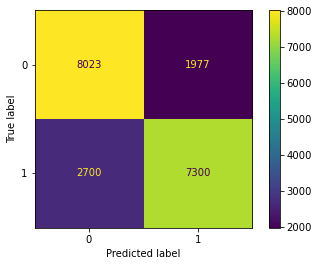

In [13]:
y_pred = log_reg.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [16]:
print('Validation Acc: ', 100*np.sum(y_pred == y_val)/len(y_val))
print('Validation F1 Score: ', f1_score(y_val, y_pred))

Validation Acc:  76.615
Validation F1 Score:  0.757379260258339


### Evaluation on Test set

In [17]:
test_real = r'../data/raw/real_vs_fake/real-vs-fake/test/real/'
test_fake = r'../data/raw/real_vs_fake/real-vs-fake/test/fake/'
X_test, y_test = get_data(test_real, test_fake, -1, True, True, 128)

100%|██████████| 10000/10000 [00:59<00:00, 169.05it/s]


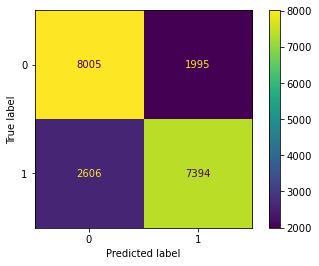

In [21]:
y_pred = log_reg.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=log_reg.classes_)
disp.plot()

plt.show()

In [19]:
f1_score(y_test, y_pred)

0.762700500283666

In [20]:
print('Test Acc: ', 100*np.sum(y_pred == y_val)/len(y_val))

Test Acc:  76.995
